In [1]:
%matplotlib widget
import gudhi as gd
from gudhi import hera
from gudhi import representations
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity
from numpy.random import default_rng
from sklearn.datasets import fetch_openml
from sklearn import manifold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from scipy import interpolate
from scipy.optimize import minimize
import time

In [2]:
rng = default_rng(seed=42)

In [3]:
def gkern(l=5, sig=1.):
    """\
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

In [4]:
def CreateComplex(nPoints, NoiseLevel):
    sig = 3
    rad = 3*sig
    ker = gkern( l = 2*rad+1 , sig = 3)
    
    xs = rng.integers(low = rad, high = 100-rad, size = nPoints)
    ys = rng.integers(low = rad, high = 100-rad, size = nPoints)

    
    bitmap = np.zeros((100,100))
    
    for i in range(nPoints):
        for j in range(-rad, rad+1):
            for k in range(-rad,rad+1):
                bitmap[xs[i]+j][ys[i]+k] = bitmap[xs[i]+j][ys[i]+k] + ker[rad+j][rad+k]

        
    #return bitmap
    offset = 64
    
    bitmap = bitmap-np.min(bitmap)
    bitmap = bitmap / np.max(bitmap)
    bitmap = 2*bitmap+offset
    noise = np.zeros_like(bitmap)
    for i in range(0,NoiseLevel):
        x = rng.integers(low=1, high = 99)
        y = rng.integers(low=1, high = 99)
        bitmap[x,y]=offset+(offset-1)*(2*rng.random()-1)
        bitmap[x+1,y] = 0
        bitmap[x+1,y-1] = 0
        bitmap[x,y-1] = 0
        bitmap[x-1,y-1] = 0
        bitmap[x-1,y] = 0
        bitmap[x-1,y+1] = 0
        bitmap[x,y+1] = 0
        bitmap[x+1,y+1] = 0
    #noise = np.random.choice([0, 1], size=bitmap.shape, p=[1-NoiseLevel, NoiseLevel])
    #noise = noise * (rng.exponential(scale=1.0, size=bitmap.shape)+2)
    #noise=noise*5
    #bitmap = bitmap + noise
    #bitmap = bitmap-np.min(bitmap)
    #bitmap = bitmap / np.max(bitmap)
    return bitmap

In [5]:
def CreatePD(nPoints, NoiseLevel, dim=1, filtration="upper"):
    if(filtration =="upper"):
        cplx = CreateComplex(nPoints,NoiseLevel)
    elif(filtration == "lower"):
         cplx = CreateComplex(nPoints,NoiseLevel)
         
    cc = gd.CubicalComplex(dimensions = list(cplx.shape),top_dimensional_cells = np.reshape(cplx,-1))

    cc.compute_persistence()

    PD = cc.persistence_intervals_in_dimension(dim)
    return PD

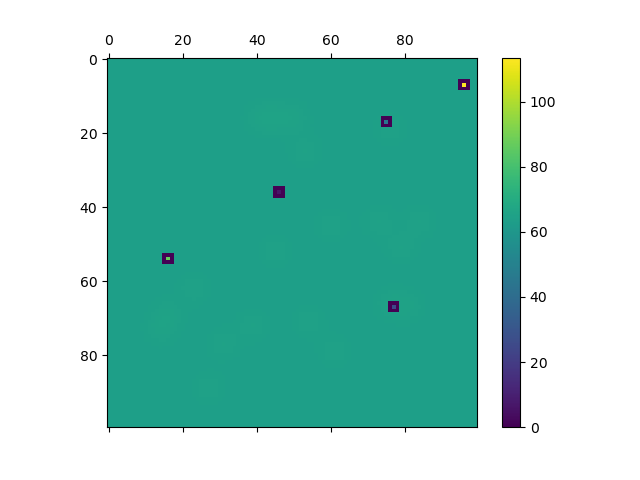

In [6]:
cplx = CreateComplex(20,5)
f,ax = plt.subplots()
img = ax.matshow(cplx)
plt.colorbar(img)
plt.show()

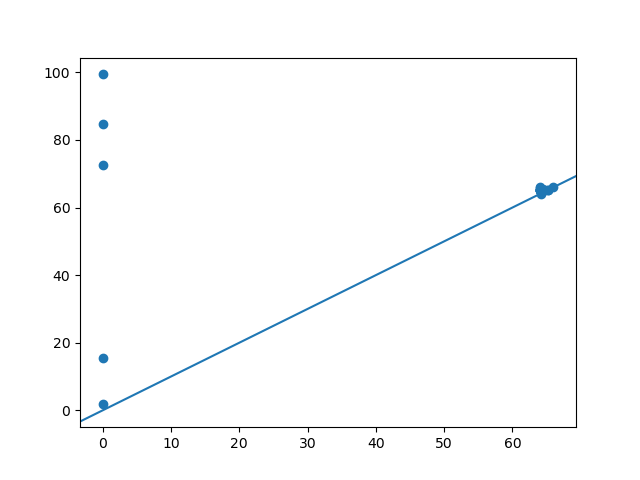

[[ 0.          1.92764599]
 [ 0.         15.43078927]
 [64.1351267  64.14284618]
 [64.00566735 65.05549847]
 [64.20450306 65.05549847]
 [64.01346954 65.05549847]
 [64.01650096 65.05549847]
 [64.         65.05549847]
 [64.55820947 65.06031898]
 [64.00938907 65.06031898]
 [64.59841237 65.06261036]
 [64.46682657 65.06261036]
 [64.65148706 65.06488754]
 [64.66696475 65.06488754]
 [64.82172805 65.07964138]
 [64.07225029 65.08903045]
 [65.12761075 65.15822237]
 [65.12761075 65.16918398]
 [64.         65.22877965]
 [64.00163198 65.69035421]
 [65.99691754 66.        ]
 [64.         66.        ]
 [ 0.         72.66139069]
 [ 0.         84.77120793]
 [ 0.         99.37185791]]


In [7]:
PD = CreatePD(20,5)
f,ax = plt.subplots()
ax.axline((0,0),slope=1)
ax.scatter(PD[:,0], PD[:,1])
#ax.set_xlim((0,1.1))
#ax.set_ylim((0,1.1))
plt.show()
print(PD)

In [8]:
def bottleneck_profile_jump_times(X,Y):
    return np.array([gd.prokhorov_distance(X, Y, np.array([n])) for n in range(0,len(X)+len(Y))])

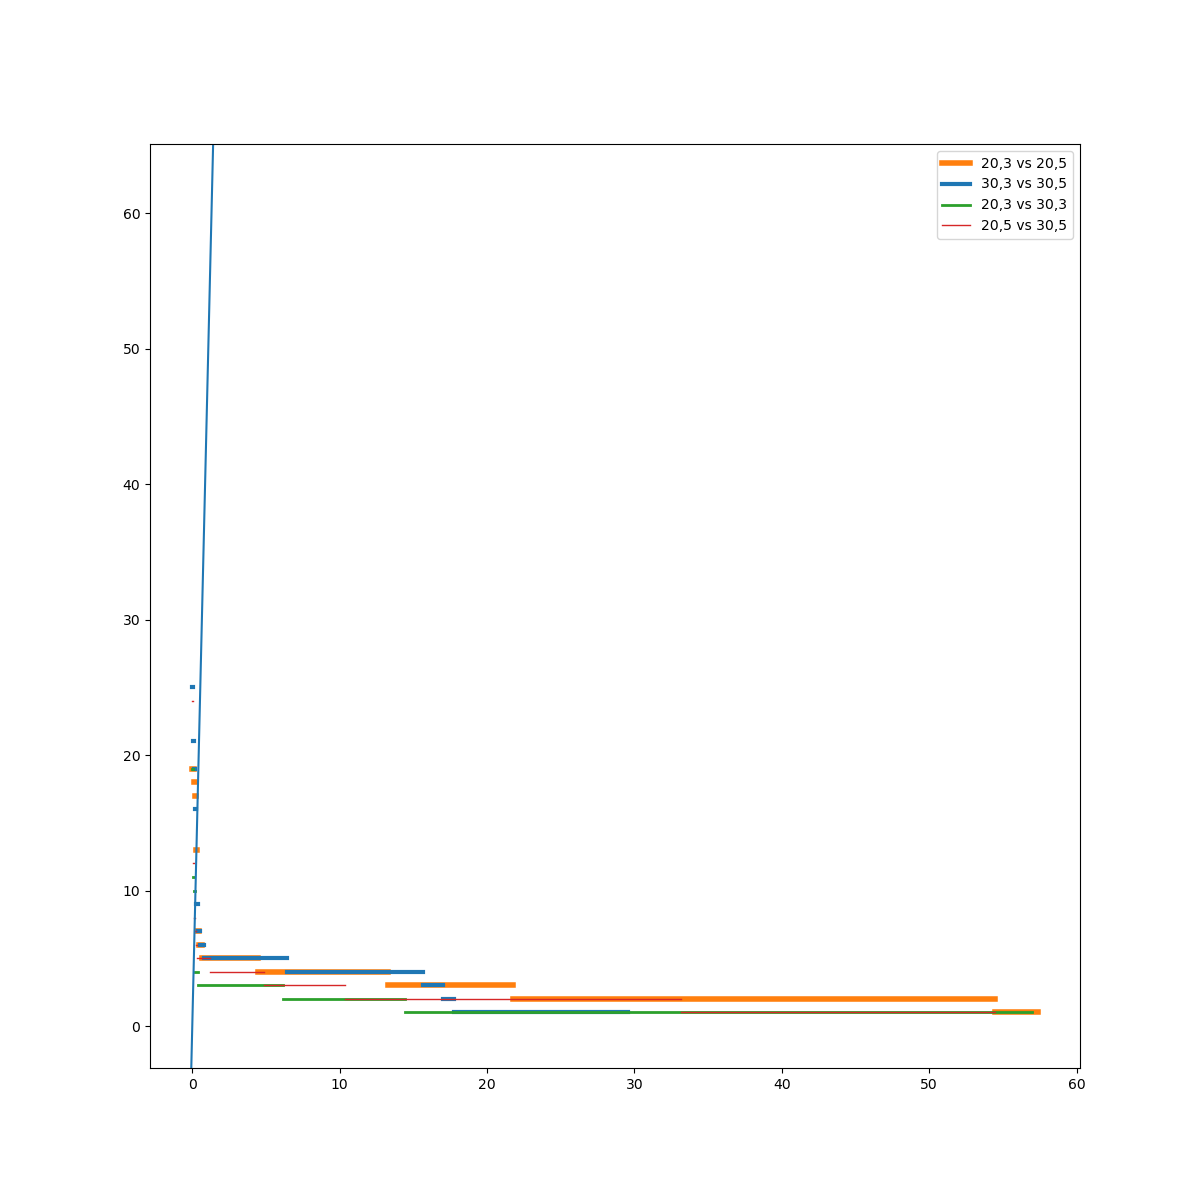

In [9]:
#5 features
PD11 = CreatePD(20,3)
PD12 = CreatePD(20,5)

#2 features
PD21 = CreatePD(30,3)
PD22 = CreatePD(30,5)

#r= np.linspace(0,1,1000)
#bp11 = np.array([gd.bottleneck_profile(PD11,PD12, r0) for r0 in r])
#bp22 = np.array([gd.bottleneck_profile(PD21,PD22, r0) for r0 in r])
#bp12 = np.array([gd.bottleneck_profile(PD11,PD21, r0) for r0 in r])
#bp21 = np.array([gd.bottleneck_profile(PD12,PD22, r0) for r0 in r])

n_points = 2*max([len(PD11),len(PD12),len(PD21),len(PD22)])
d_vals = np.linspace(0,n_points,n_points+1)

r_vals11 = [gd.prokhorov_distance(PD11, PD12, np.array([r])) for r in d_vals]
r_vals22 = [gd.prokhorov_distance(PD21, PD22, np.array([r])) for r in d_vals]
r_vals12 = [gd.prokhorov_distance(PD11, PD21, np.array([r])) for r in d_vals]
r_vals21 = [gd.prokhorov_distance(PD12, PD22, np.array([r])) for r in d_vals]

f,ax=plt.subplots(figsize=(12,12))
#ax.plot(r,bp11, label = "5 vs 5 points")
#ax.plot(r,bp22, label = "2 vs 2 points")
#ax.plot(r,bp12, label = "5 vs 2 points")
#ax.plot(r,bp21, label = "5 vs 2 points")
for i in range(1,n_points+1):
    ax.plot((r_vals11[i],r_vals11[i-1]),(i, i), c='tab:orange', ls='-', linewidth = 4.0, label = '20,3 vs 20,5')
    ax.plot((r_vals22[i],r_vals22[i-1]),(i, i), c='tab:blue', ls='-', linewidth = 3.0, label = '30,3 vs 30,5')
    ax.plot((r_vals12[i],r_vals12[i-1]),(i, i), c='tab:green', ls='-', linewidth = 2.0, label = '20,3 vs 30,3')
    ax.plot((r_vals21[i],r_vals21[i-1]),(i, i), c='tab:red', ls='-', linewidth = 1.0, label = '20,5 vs 30,5')


#ax.set_ylim((-1,12))
#ax.set_xlim((-0.05,0.1))
plt.axline((0,0),(1,46))

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
plt.show()

In [10]:
MCIterations = 200

rvals_11_12 = []
rvals_11_21 = []
rvals_11_22 = []
rvals_12_21 = []
rvals_12_22 = []
rvals_21_22 = []

bpvals_11_12 = []
bpvals_11_21 = []
bpvals_11_22 = []
bpvals_12_21 = []
bpvals_12_22 = []
bpvals_21_22 = []

xs = np.linspace(0,1,1000)



for j in tqdm(range(0,MCIterations)):
    #5 features
    PD11 = CreatePD(20,3)
    PD12 = CreatePD(20,5)

    #2 features
    PD21 = CreatePD(15,3)
    PD22 = CreatePD(15,5)
    
    rvals_11_12.append(bottleneck_profile_jump_times(PD11,PD12))
    rvals_11_21.append(bottleneck_profile_jump_times(PD11,PD21))
    rvals_11_22.append(bottleneck_profile_jump_times(PD11,PD22))
    rvals_12_21.append(bottleneck_profile_jump_times(PD12,PD21))
    rvals_12_22.append(bottleneck_profile_jump_times(PD12,PD22))
    rvals_21_22.append(bottleneck_profile_jump_times(PD21,PD22))
    
    bpvals_11_12.append([gd.bottleneck_profile(PD11,PD12,t) for t in  xs])
    bpvals_11_21.append([gd.bottleneck_profile(PD11,PD21,t) for t in  xs])
    bpvals_11_22.append([gd.bottleneck_profile(PD11,PD22,t) for t in  xs])
    bpvals_12_21.append([gd.bottleneck_profile(PD12,PD21,t) for t in  xs])
    bpvals_12_22.append([gd.bottleneck_profile(PD12,PD22,t) for t in  xs])
    bpvals_21_22.append([gd.bottleneck_profile(PD21,PD22,t) for t in  xs])
    
    

  0%|          | 0/200 [00:00<?, ?it/s]

In [11]:
rvals_array = [rvals_11_12, rvals_11_21, rvals_11_22, rvals_12_21, rvals_12_22, rvals_21_22]
bpvals_array = [bpvals_11_12, bpvals_11_21, bpvals_11_22, bpvals_12_21, bpvals_12_22, bpvals_21_22]

minlen_array = []
mean_rvals_array = []
std_rvals_array = []
for rvals in rvals_array:
    minlen = np.min([len(arr) for arr in rvals])
    minlen_array.append(minlen)
    mean_rvals_array.append(np.array([np.mean([arr[i] for arr in rvals]) for i in  range(0,minlen)]))
    std_rvals_array.append(np.array([np.std([arr[i] for arr in rvals]) for i in  range(0,minlen)]))
    
mean_bpvals_array = []
std_bpvals_array = []
for bpvals in bpvals_array:
    mean_bpvals_array.append(np.mean(bpvals, axis = 0))
    std_bpvals_array.append(np.std(bpvals, axis = 0))

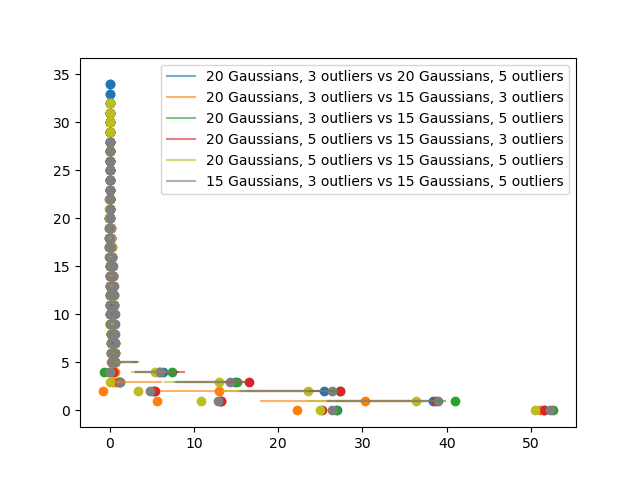

In [12]:
f,ax = plt.subplots()
rvals_array = [rvals_11_12, rvals_11_21, rvals_11_22, rvals_12_21, rvals_12_22, rvals_21_22]
labs = ["20 Gaussians, 3 outliers vs 20 Gaussians, 5 outliers",
        "20 Gaussians, 3 outliers vs 15 Gaussians, 3 outliers",
        "20 Gaussians, 3 outliers vs 15 Gaussians, 5 outliers",
        "20 Gaussians, 5 outliers vs 15 Gaussians, 3 outliers",
        "20 Gaussians, 5 outliers vs 15 Gaussians, 5 outliers",
        "15 Gaussians, 3 outliers vs 15 Gaussians, 5 outliers"]
cols = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:olive", "tab:grey"]
for j in range(0,len(rvals_array)):
    for i in range(0,len(mean_rvals_array[j])-1):
        ax.plot((mean_rvals_array[j][i],mean_rvals_array[j][i+1]),(i+1,i+1), c= cols[j], label = labs[j], alpha = 0.6)
        ax.scatter([mean_rvals_array[j][i]-std_rvals_array[j][i],mean_rvals_array[j][i]+std_rvals_array[j][i]],[i,i], c=cols[j])
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))    
ax.legend(by_label.values(), by_label.keys())
plt.show()

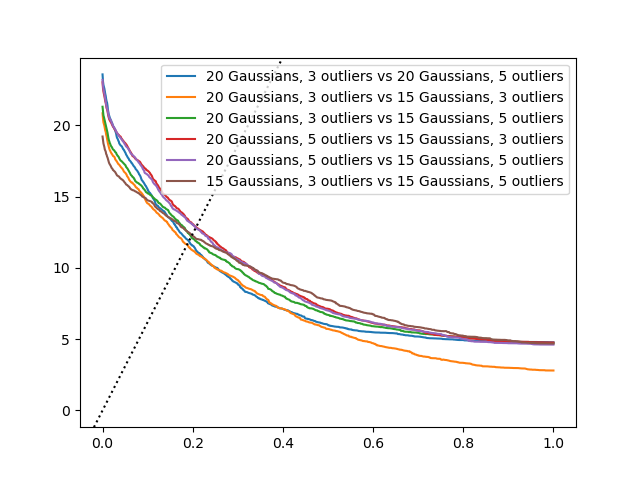

In [13]:
f,ax = plt.subplots()
for i in range(0, len(bpvals_array)):
    ax.plot(xs, np.array(mean_bpvals_array[i]), label = labs[i])
    
ax.axline((0,0), slope = 62, color = "k", ls = ":")   
#ax.axline((0,0), slope = 39, color = "k", ls = ":")   
ax.legend()
plt.show()

In [14]:
def intersection_locus(bp, slope):
    #return xs[np.argwhere(np.diff(np.sign(bp-f))).flatten()][0]
    idx0 = np.argwhere(np.diff(np.sign(bp-slope*xs))).flatten()[0]
    x = (bp[idx0]+xs[idx0]*(bp[idx0]-bp[idx0+1]))/(slope + bp[idx0]-bp[idx0+1]) 
    return x

In [15]:
mean_bpvals_array[1][364]

7.81

In [16]:
intersection_locus(mean_bpvals_array[1], 62)

0.18758051828029257

In [17]:
def score_linear_function(slope, inter, intra):
    score = 1
    inter_dists = [intersection_locus(bp, slope) for bp in inter]
    intra_dists = [intersection_locus(bp, slope) for bp in intra]
    #score = np.sum(intra_dists)/len(intra_dists) - np.sum(inter_dists)/len(inter_dists)
    score = np.max(intra_dists)/ np.min(inter_dists)
    #diffs = [intra_dists[i] - inter_dists[j] for i in range(0,len(intra_dists)) for j in range(0,len(inter_dists))]
    #score = np.mean(diffs)
    return score

In [18]:
inter_cluster_bp = [mean_bpvals_array[i] for i in range(1,5)]
intra_cluster_bp = [mean_bpvals_array[i] for i in [0,5]]
score_linear_function(41,inter_cluster_bp, intra_cluster_bp)

1.0999005013063166

In [19]:
minval = 999999
minidx = 0
for s in tqdm(range(10,2000)):
    score = score_linear_function(s, inter_cluster_bp, intra_cluster_bp)
    if score <= minval:
        minval = score
        minidx = s
        
print(minidx, minval)

  0%|          | 0/1990 [00:00<?, ?it/s]

92 1.0241913905782964


In [20]:
minimize(score_linear_function, x0 = 68, args=(inter_cluster_bp, intra_cluster_bp), method="Nelder-Mead")

 final_simplex: (array([[69.2203186 ],
       [69.22026672]]), array([1.05010457, 1.05010457]))
           fun: 1.0501045709947063
       message: 'Optimization terminated successfully.'
          nfev: 50
           nit: 24
        status: 0
       success: True
             x: array([69.2203186])

In [52]:
print(gd.bottleneck_distance(PD11,PD12))
print(gd.bottleneck_distance(PD21,PD22))
print(gd.bottleneck_distance(PD11,PD21))
print(gd.bottleneck_distance(PD12,PD22))

34.57385057749198
27.209315207426386
56.225146678793664
46.40699980888235


In [53]:
print(gd.hera.wasserstein_distance(PD11,PD12, order = 1, internal_p=1))
print(gd.hera.wasserstein_distance(PD21,PD22, order = 1, internal_p=1))
print(gd.hera.wasserstein_distance(PD11,PD21, order = 1, internal_p=1))
print(gd.hera.wasserstein_distance(PD12,PD22, order = 1, internal_p=1))


128.21603702859085
164.8037473968619
174.53797672330842
131.21171970167222


In [36]:
n_samples = 200
n_gaussians1 = 20
n_gaussians2 = 15
n_noise1 = 3
n_noise2 = 5
PDs = []
for i in range(0,n_samples):
    PDs.append(CreatePD(n_gaussians1,n_noise1))
for i in range(0,n_samples):
    PDs.append(CreatePD(n_gaussians1,n_noise2))
for i in range(0,n_samples):
    PDs.append(CreatePD(n_gaussians2,n_noise1))
for i in range(0,n_samples):
    PDs.append(CreatePD(n_gaussians2,n_noise2))
    
y = [i//(2*n_samples) for i in range(0,len(PDs))]

In [37]:

X_train, X_test, y_train, y_test = train_test_split(PDs, y, test_size=0.4, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5, metric = "precomputed")


In [93]:
tic = time.time()
BD = gd.representations.BottleneckDistance(n_jobs=-1)
BD.fit(X_train)
B_train = BD.transform(X_train)
B_test = BD.transform(X_test)
print("Bottleneck done in ", time.time()-tic)
knn.fit(B_train, y_train)
cv_scores = cross_val_score(knn, B_train, y_train, cv=5)
print("Bottleneck training accuracy: ",np.mean(cv_scores))
score = knn.score(B_test, y_test)
print("Bottleneck test accuracy: ",score)

Bottleneck done in  2.264545440673828
Bottleneck training accuracy:  0.5250000000000001
Bottleneck test accuracy:  0.5125


In [94]:
tic = time.time()
W1D = gd.representations.WassersteinDistance(n_jobs=-1, order=1, internal_p =1)
W1D.fit(X_train)
W1_train = W1D.transform(X_train)
W1_test = W1D.transform(X_test)
print("1-Wasserstein done in ", time.time()-tic)
knn.fit(W1_train, y_train)
cv_scores = cross_val_score(knn, W1_train, y_train, cv=5)
print("1-Wasserstein training accuracy: ",np.mean(cv_scores))
score = knn.score(W1_test, y_test)
print("1-Wasserstein test accuracy: ",score)

1-Wasserstein done in  2.530327558517456
1-Wasserstein training accuracy:  0.5583333333333333
1-Wasserstein test accuracy:  0.4875


In [95]:
tic = time.time()
W2D = gd.representations.WassersteinDistance(n_jobs=-1, order=2, internal_p =2)
W2D.fit(X_train)
W2_train = W2D.transform(X_train)
W2_test = W2D.transform(X_test)
print("2-Wasserstein done in ", time.time()-tic)
knn.fit(W2_train, y_train)
cv_scores = cross_val_score(knn, W2_train, y_train, cv=5)
print("2-Wasserstein training accuracy: ",np.mean(cv_scores))
score = knn.score(W2_test, y_test)
print("2-Wasserstein test accuracy: ",score)

2-Wasserstein done in  8.805550575256348
2-Wasserstein training accuracy:  0.4833333333333334
2-Wasserstein test accuracy:  0.4875


In [96]:
slopes = np.linspace(10, 100, 91)
argmax = 0
maxi = 0

for s in slopes:
    PD = gd.representations.ProkhorovDistance(n_jobs = -1, coefs = np.array([0,s]))
    PD.fit(X_train)
    P_train = PD.transform(X_train)
    knn.fit(P_train, y_train)
    cv_scores = cross_val_score(knn, P_train, y_train, cv=5)
    print(s, np.mean(cv_scores))
    if(np.mean(cv_scores)>maxi):
        argmax = s
        maxi = np.mean(cv_scores)
        
print("best slope: ",argmax)

10.0 0.6416666666666667
11.0 0.6916666666666667
12.0 0.725
13.0 0.7333333333333334
14.0 0.7583333333333333
15.0 0.7416666666666666
16.0 0.725
17.0 0.7583333333333333
18.0 0.725
19.0 0.775
20.0 0.7583333333333333
21.0 0.7916666666666667
22.0 0.7666666666666666
23.0 0.7916666666666667
24.0 0.8083333333333333
25.0 0.7999999999999999
26.0 0.8083333333333333
27.0 0.825
28.0 0.7916666666666667
29.0 0.7833333333333334
30.0 0.775
31.0 0.7916666666666667
32.0 0.7666666666666667
33.0 0.7833333333333334
34.0 0.8166666666666667
35.0 0.775
36.0 0.7666666666666667
37.0 0.7416666666666666
38.0 0.7750000000000001
39.0 0.8
40.0 0.7749999999999999
41.0 0.775
42.0 0.8166666666666667
43.0 0.8166666666666667
44.0 0.7999999999999999
45.0 0.7916666666666667
46.0 0.8166666666666667
47.0 0.775
48.0 0.7833333333333333
49.0 0.8
50.0 0.7999999999999999
51.0 0.8166666666666667
52.0 0.7833333333333333
53.0 0.7999999999999999
54.0 0.775
55.0 0.7833333333333334
56.0 0.8
57.0 0.8
58.0 0.8
59.0 0.7916666666666667
60.0 

In [103]:
tic = time.time()
PD = gd.representations.ProkhorovDistance(n_jobs=-1, coefs = np.array([0,82]))
PD.fit(X_train)
P_train = PD.transform(X_train)
P_test = PD.transform(X_test)
print("Prokhorov done in ", time.time()-tic)
cv_scores = cross_val_score(knn, P_train, y_train, cv=5)
print("Prokhorov training accuracy: ",np.mean(cv_scores))
score = knn.score(P_test, y_test)
print("Prokhorov test accuracy: ",score)

Prokhorov done in  1.602827787399292
Prokhorov training accuracy:  0.8666666666666668
Prokhorov test accuracy:  0.85


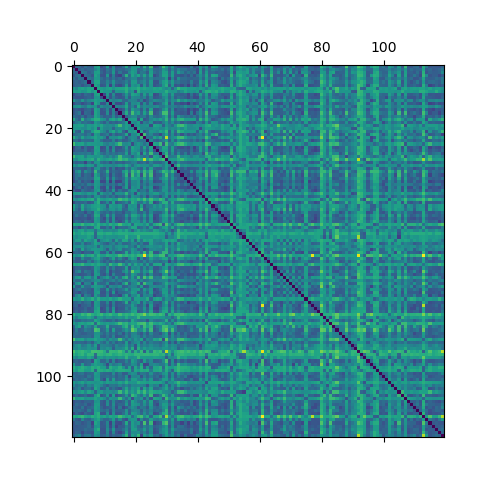

In [98]:
plt.matshow(P_train)

In [38]:
slopes = np.linspace(10,100,91)#range(10,100)
slope_scores = []
test_accuracies = []
for s in tqdm(slopes):
    slope_scores.append( score_linear_function(s,inter_cluster_bp, intra_cluster_bp))
    PD = gd.representations.ProkhorovDistance(n_jobs = -1, coefs = np.array([0,s]))
    PD.fit(X_train)
    P_train = PD.transform(X_train)
    knn.fit(P_train, y_train)
    cv_scores = cross_val_score(knn, P_train, y_train, cv=5)
    test_accuracies.append(cv_scores)
    

  0%|          | 0/91 [00:00<?, ?it/s]

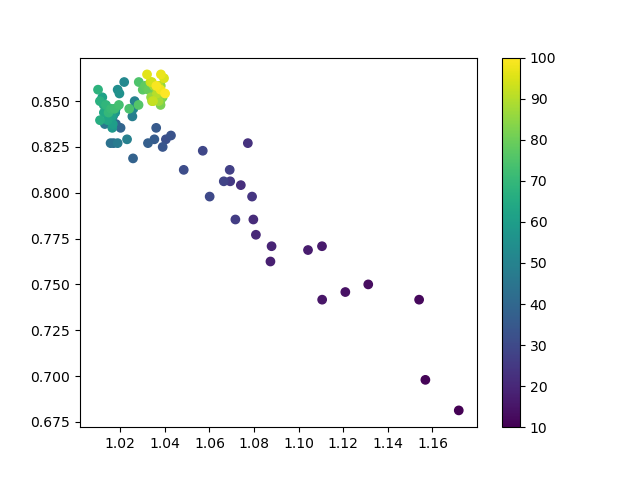

In [40]:
f,ax = plt.subplots()
whatever = ax.scatter(slope_scores, np.mean(test_accuracies,axis = 1), c=slopes)
plt.colorbar(whatever, ax=ax)
plt.show()

In [12]:
import torch
from torch import nn, tensor
from torch.autograd import Variable
criterion = nn.CrossEntropyLoss()
input = torch.tensor([[3.2, 1.3,0.2, 0.8]],dtype=torch.float)
target = torch.tensor([0], dtype=torch.long)
criterion(input, target)

tensor(0.2547)

In [15]:
target.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn